In [1]:
import pandas as pd
import numpy as np
import os

from joblib import dump, load

import matplotlib 
import matplotlib.pyplot as plt 

In [2]:
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/"
trackmate_path = f"{ROOT_DIR}spots.csv"

df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

print(f"{df.shape}")
df.head()

(9160, 46)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_X0,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY
0,ID11264,11264,0.0,0.621232,13.624937,735.647836,0.0,0.0,0,8.959511,...,-0.019652,0.039077,5.524627,4.101917,-1.010200,1.346840,70.287885,33.467752,0.788565,0.943574
1,ID11265,11265,1.0,0.619526,799.905202,718.453691,0.0,0.0,0,4.922364,...,-0.002425,-0.023146,3.073098,2.739228,1.421361,1.121885,25.920117,20.999318,0.738646,0.932773
2,ID11266,11266,2.0,0.576961,1070.928972,211.395927,0.0,0.0,0,9.868752,...,0.008092,-0.016601,4.390829,4.023751,0.567798,1.091228,54.875924,27.633858,0.903043,0.975104
3,ID11267,11267,3.0,0.553324,1166.407990,861.873077,0.0,0.0,0,2.901323,...,-0.017963,-0.028914,2.645642,2.177968,1.307088,1.214729,17.747107,18.099917,0.680745,0.894118
4,ID11268,11268,NaN,0.542137,1011.519677,23.141251,0.0,0.0,0,9.209876,...,0.015370,0.013344,4.075843,3.833116,1.674520,1.063323,48.571030,27.242518,0.822418,0.941176


In [3]:
# a few quick exclusions based on size and track length

min_track_length = 20
min_mean_size = 9

print(f"{df.shape=}")
print(f"{df['TRACK_ID'].nunique()=}")

df = df.sort_values(by=['TRACK_ID', 'FRAME'])

df['STEP'] =  df.groupby('TRACK_ID').transform('cumcount')
df['MAX_STEP'] =  df.groupby('TRACK_ID')['STEP'].transform('max')


####### perform all filtering on a temporary dataframe
tmp = df.copy()

filtered = df.groupby('TRACK_ID')['STEP'].max().reset_index()
filtered = filtered[filtered['STEP'] > min_track_length]
tmp = tmp[tmp['TRACK_ID'].isin(filtered['TRACK_ID'])]

print(f"\nfilter 1:")
print(f"\t{tmp.shape=}")
print(f"\t{tmp['TRACK_ID'].nunique()=}")

# df.loc[:, 'MEAN_RADIUS'] =  df.groupby(['TRACK_ID'])['RADIUS'].mean()

filtered = tmp.groupby('TRACK_ID')['RADIUS'].mean().reset_index()
filtered = filtered[filtered['RADIUS'] > min_mean_size]
tmp = tmp[tmp['TRACK_ID'].isin(filtered['TRACK_ID'])]

print(f"\nfilter 2:")
print(f"\t{tmp.shape=}")
print(f"\t{tmp['TRACK_ID'].nunique()=}")


df = tmp.copy()
df = df.sort_values(by=['TRACK_ID', 'FRAME'])

filename = f"{ROOT_DIR}filtered_spots.csv"
df.to_csv(filename, index=False)
print(f"{filename=}")

df.shape=(9160, 46)
df['TRACK_ID'].nunique()=738

filter 1:
	tmp.shape=(4462, 48)
	tmp['TRACK_ID'].nunique()=128

filter 2:
	tmp.shape=(4069, 48)
	tmp['TRACK_ID'].nunique()=114
filename='/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/filtered_spots.csv'


In [4]:
list(df.columns)

['LABEL',
 'ID',
 'TRACK_ID',
 'QUALITY',
 'POSITION_X',
 'POSITION_Y',
 'POSITION_Z',
 'POSITION_T',
 'FRAME',
 'RADIUS',
 'VISIBILITY',
 'MANUAL_SPOT_COLOR',
 'MEAN_INTENSITY_CH1',
 'MEDIAN_INTENSITY_CH1',
 'MIN_INTENSITY_CH1',
 'MAX_INTENSITY_CH1',
 'TOTAL_INTENSITY_CH1',
 'STD_INTENSITY_CH1',
 'MEAN_INTENSITY_CH2',
 'MEDIAN_INTENSITY_CH2',
 'MIN_INTENSITY_CH2',
 'MAX_INTENSITY_CH2',
 'TOTAL_INTENSITY_CH2',
 'STD_INTENSITY_CH2',
 'MEAN_INTENSITY_CH3',
 'MEDIAN_INTENSITY_CH3',
 'MIN_INTENSITY_CH3',
 'MAX_INTENSITY_CH3',
 'TOTAL_INTENSITY_CH3',
 'STD_INTENSITY_CH3',
 'CONTRAST_CH1',
 'SNR_CH1',
 'CONTRAST_CH2',
 'SNR_CH2',
 'CONTRAST_CH3',
 'SNR_CH3',
 'ELLIPSE_X0',
 'ELLIPSE_Y0',
 'ELLIPSE_MAJOR',
 'ELLIPSE_MINOR',
 'ELLIPSE_THETA',
 'ELLIPSE_ASPECTRATIO',
 'AREA',
 'PERIMETER',
 'CIRCULARITY',
 'SOLIDITY',
 'STEP',
 'MAX_STEP']

(-205.14503795666354,
 212.49941700209328,
 -564.2781641946182,
 232.37490349097706)

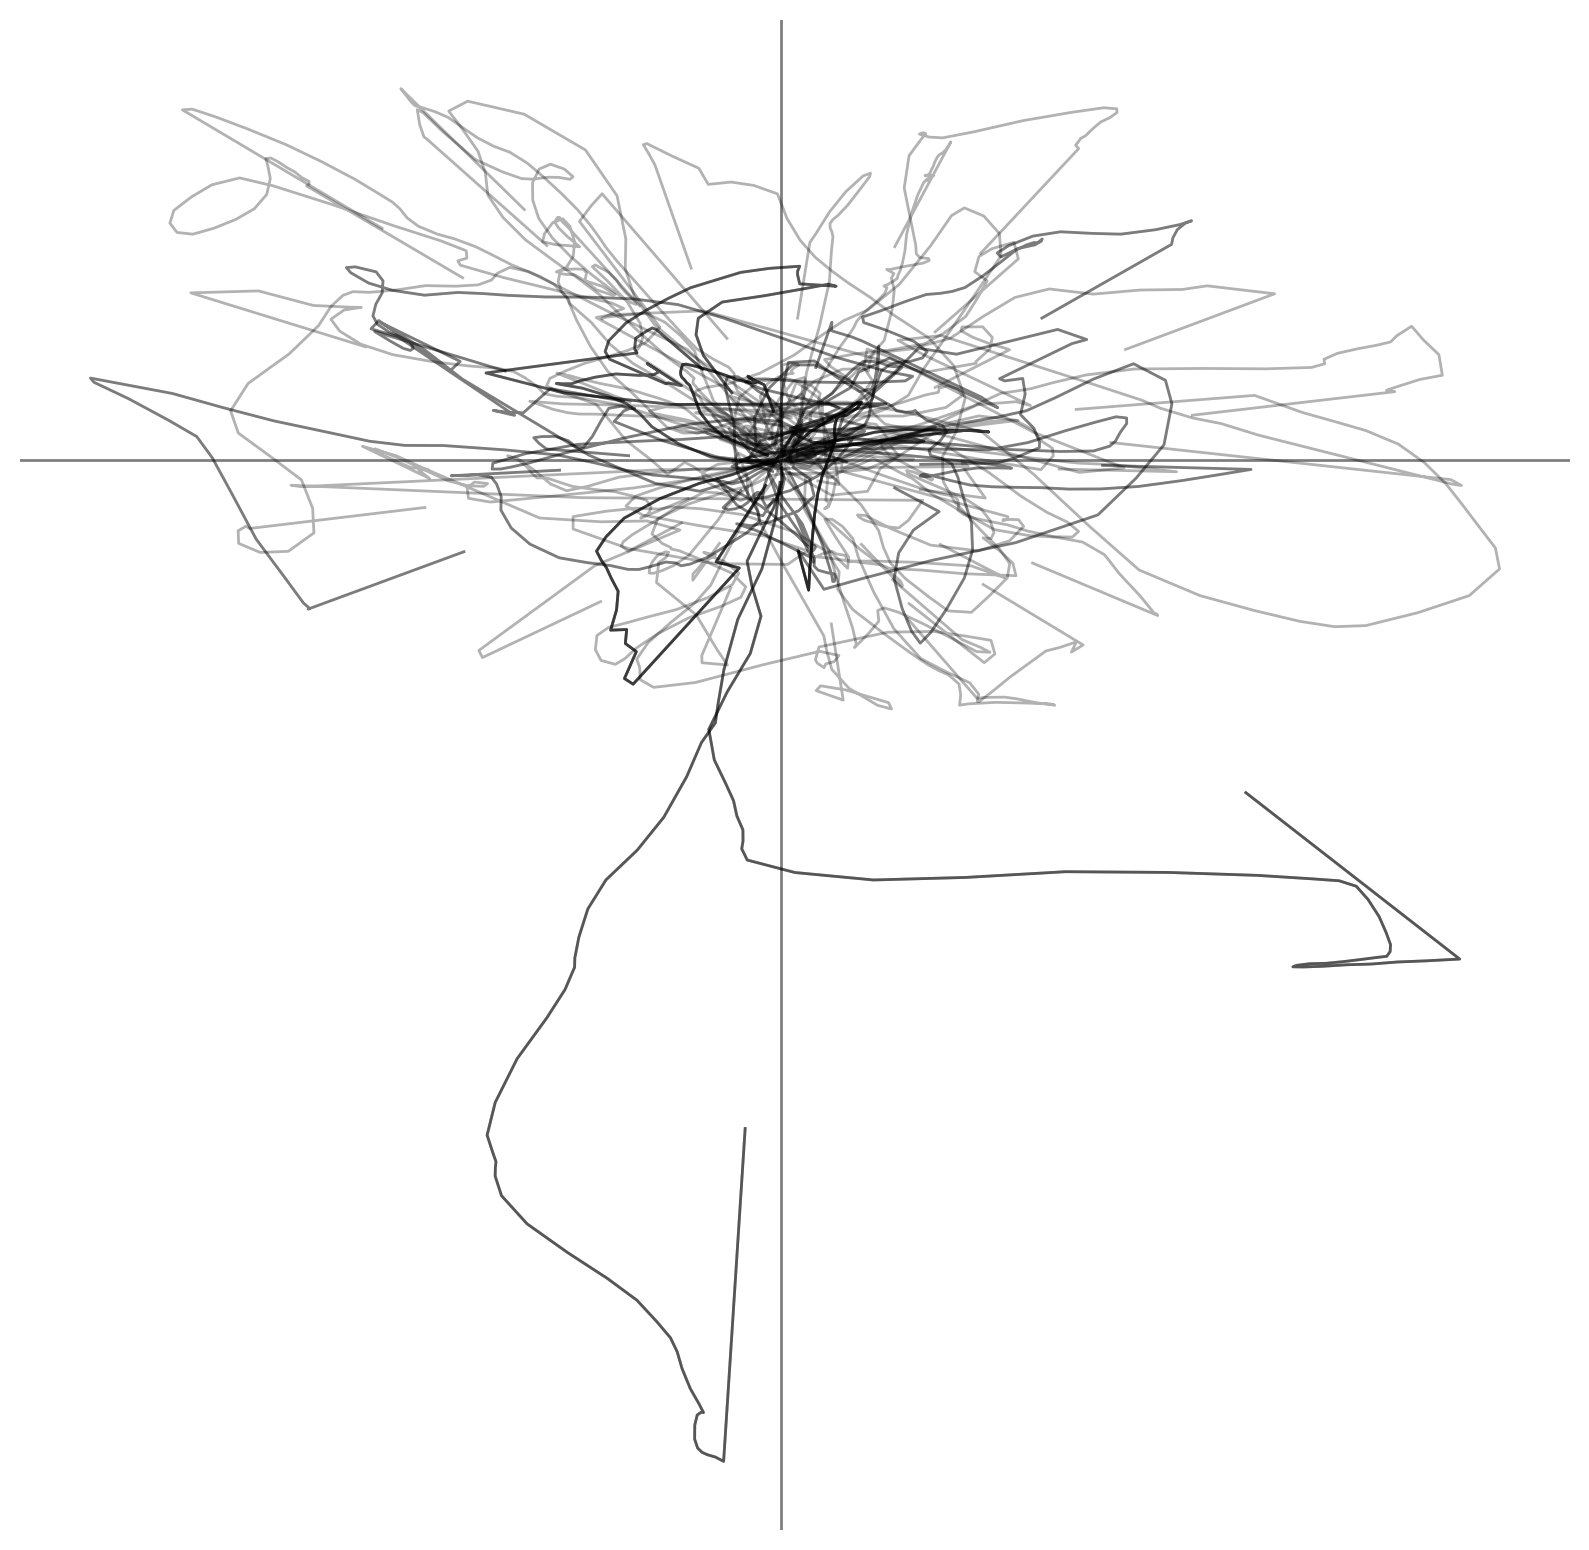

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['figure.facecolor'] = 'white'
alpha = 0.3
linewdith = 1

n = 100

tracks = np.random.choice(df['TRACK_ID'].unique(), n)

def smooth(y, box_pts=3):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

for track in tracks:
    tmp = df[df['TRACK_ID'] == track].reset_index()
    tmp = tmp.sort_values(by='FRAME')
    
    min_frame = tmp['FRAME'].min()
    
    x_scale = tmp.loc[tmp['FRAME'] == min_frame, 'POSITION_X'].iloc[0]
    y_scale = tmp.loc[tmp['FRAME'] == min_frame, 'POSITION_Y'].iloc[0]
    
    xvec = smooth(tmp['POSITION_X'] - x_scale)
    yvec = smooth(tmp['POSITION_Y'] - y_scale)

    plt.plot(xvec, yvec, c='k', alpha=alpha, lw=linewdith)

    
plt.axhline(y=0, color='k', alpha=0.5, lw=1)
plt.axvline(x=0, color='k', alpha=0.5, lw=1)
plt.axis('off')

In [9]:
"""
run PF predictions based on trainned RF model
"""

def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    
    df = df.rename(columns=rename_dict)
    return df

model = load('rf_model.joblib') 
scaler = load('rf_scaler.joblib') 

# load in the original data set

trackmate_path = f"{ROOT_DIR}spots.csv"
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')

X = [
    'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED','MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED', 'STD_INTENSITY_RED', 'CONTRAST_RED', 'SNR_RED', 
    'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN','MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN', 'STD_INTENSITY_GREEN', 'CONTRAST_GREEN', 'SNR_GREEN', 
    'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE', 'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE','STD_INTENSITY_BLUE', 'CONTRAST_BLUE', 'SNR_BLUE', 
    'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
]

target_names = ['G1', 'S', 'G2/M', 'NA']

for c in X:
    if df[c].isna().sum() > 0:
        df[c] = np.where(df[c].isna(), df[c].max(), df[c])

states = model.predict(scaler.transform(df[X]))
states = pd.DataFrame(states)
states.columns = target_names 

df = df.join(states)
df['estimate'] = df[target_names].idxmax(axis=1)
print(f"{df.shape=}")

df.shape=(9160, 51)


(-533.8321919225787, 319.89701614432346, -449.7656394563559, 389.9342311532345)

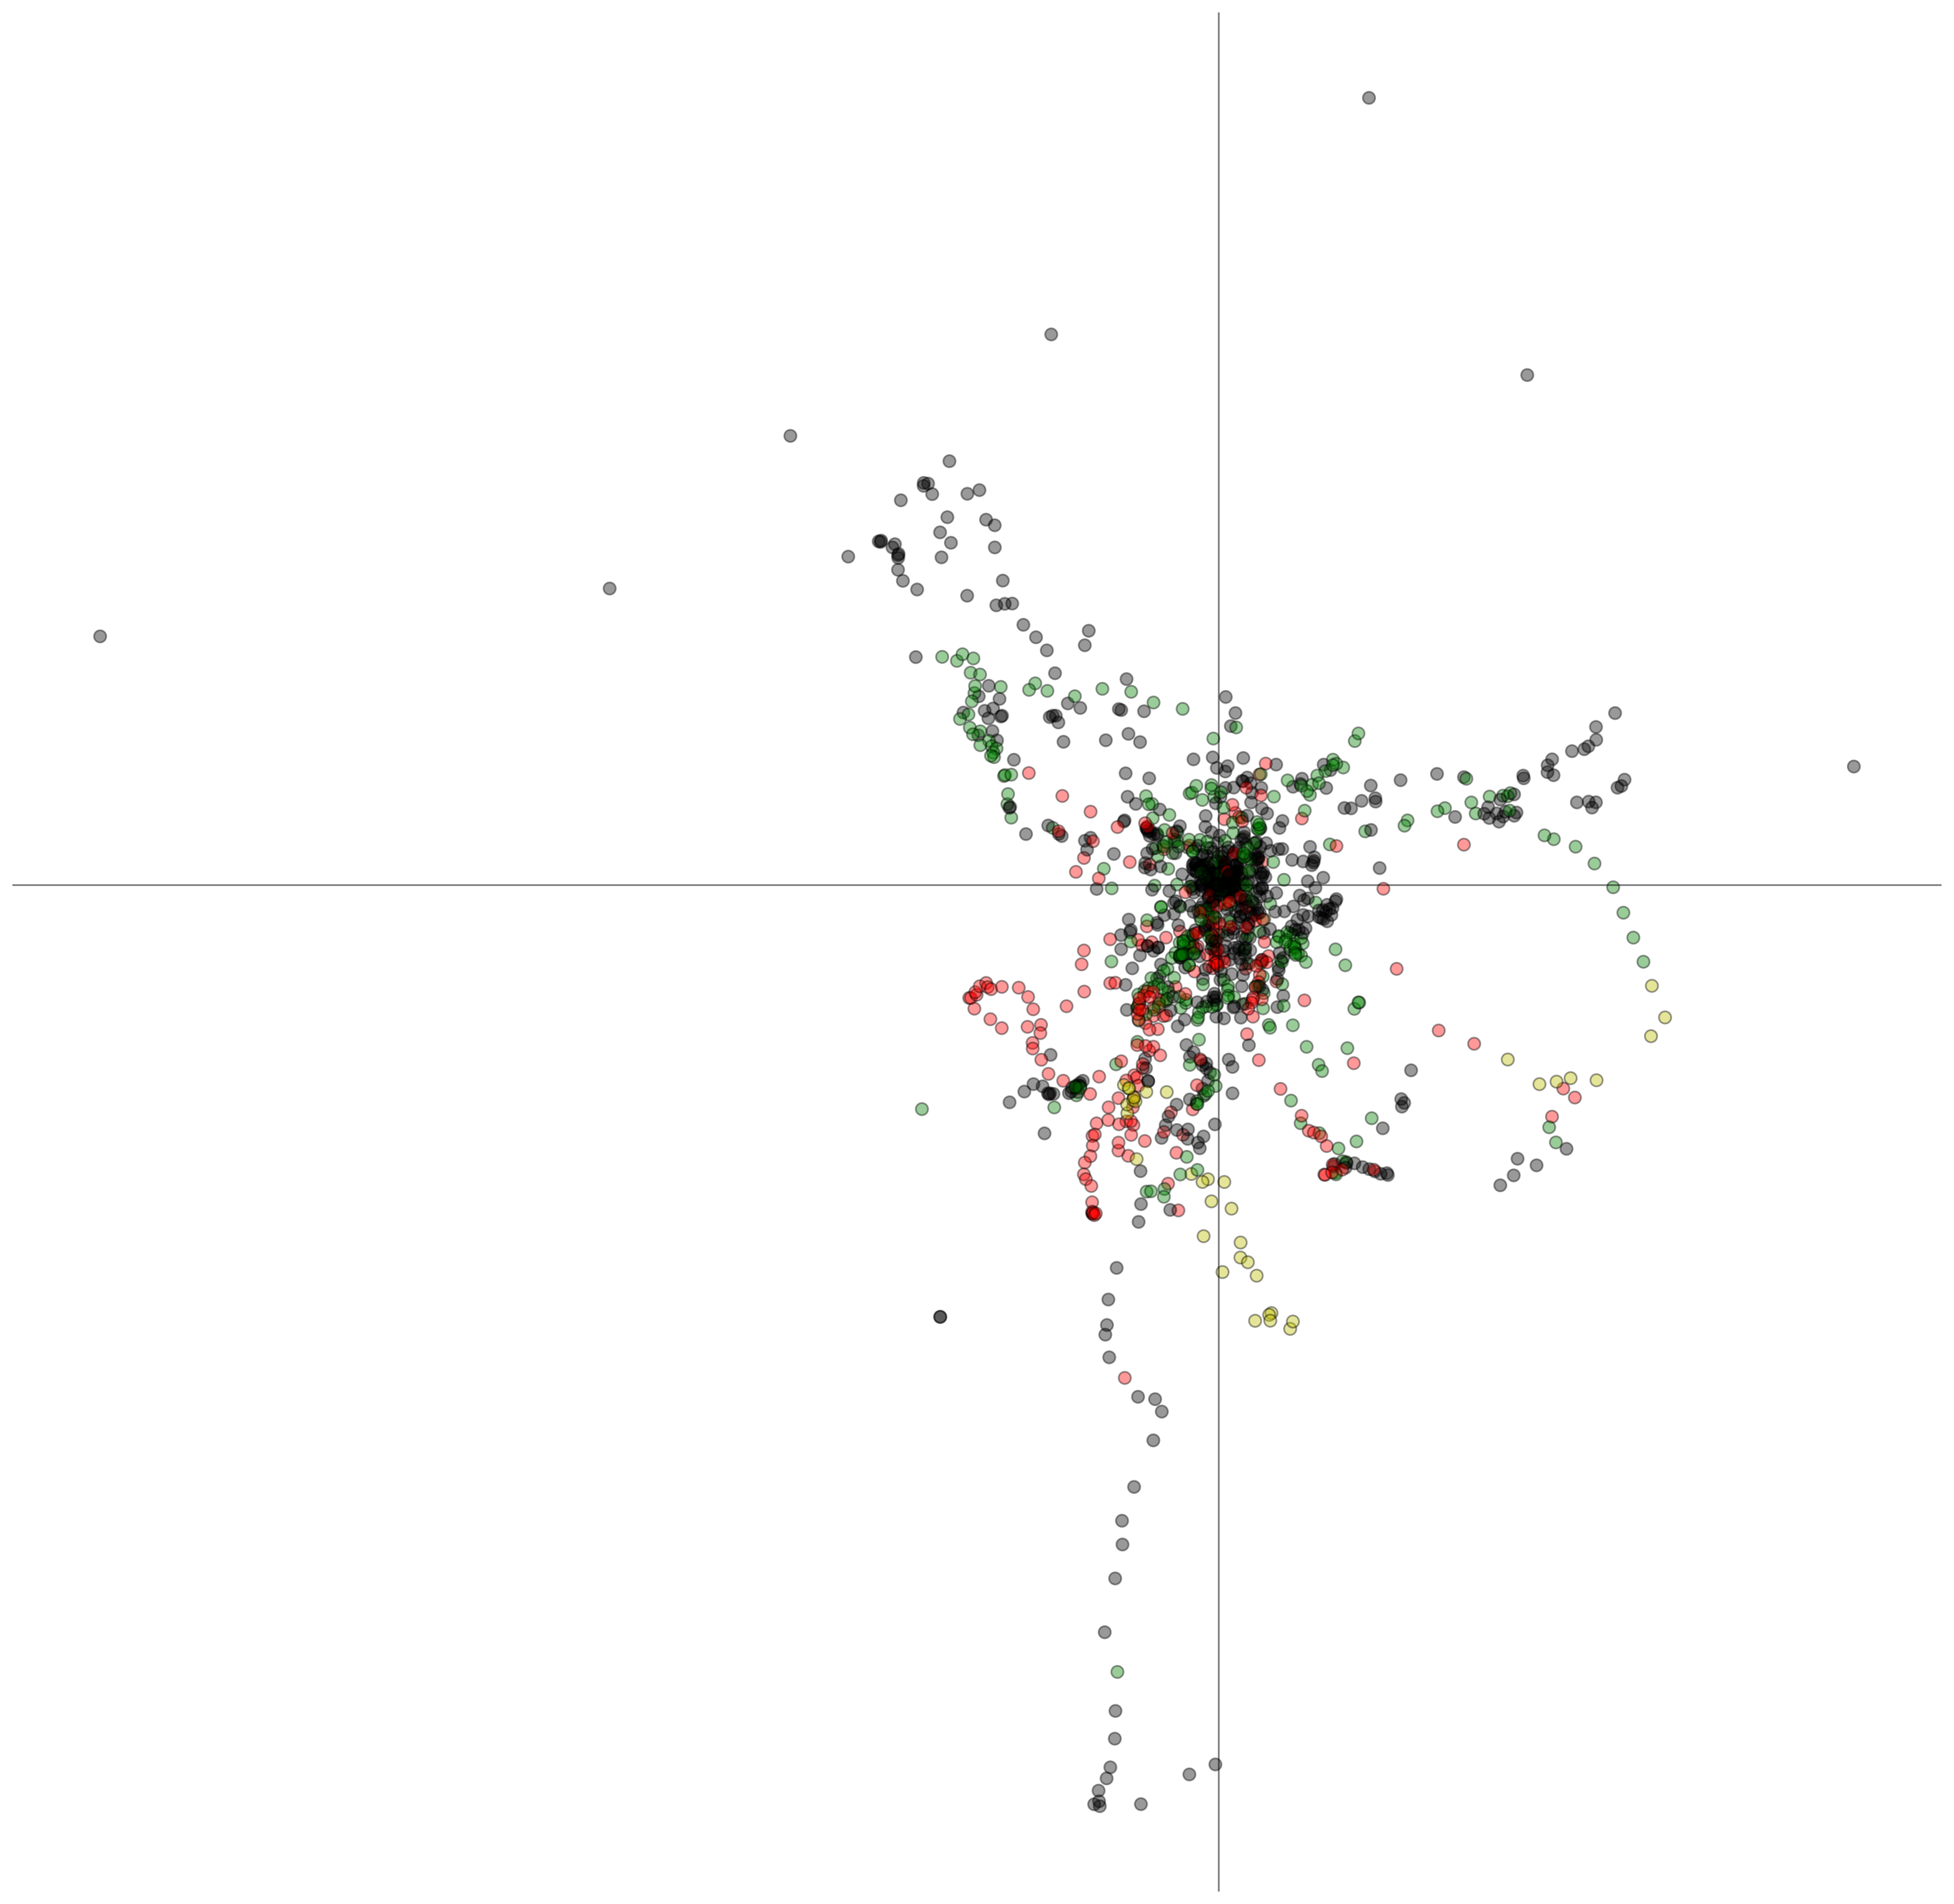

In [31]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['figure.facecolor'] = 'white'
alpha = 0.4
linewdith = 1
size=50

n = 100

colors = {
    'G1':'g', 
    'S':'r', 
    'G2/M':'y', 
    'NA' : 'k'
 }

tracks = np.random.choice(df['TRACK_ID'].unique(), n)

for track in tracks:
    tmp = df[df['TRACK_ID'] == track].reset_index()
    tmp = tmp.sort_values(by='FRAME')
    
    min_frame = tmp['FRAME'].min()
    
    x_scale = tmp.loc[tmp['FRAME'] == min_frame, 'POSITION_X'].iloc[0]
    y_scale = tmp.loc[tmp['FRAME'] == min_frame, 'POSITION_Y'].iloc[0]
    
    tmp['xvec'] = tmp['POSITION_X'] - x_scale
    tmp['yvec'] = tmp['POSITION_Y'] - y_scale
    
    for est in tmp['estimate'].unique():
        t = tmp[tmp['estimate'] == est]
    
        plt.scatter(t['xvec'], 
                    t['yvec'], 
                    c = t['estimate'].map(colors), 
                    edgecolor='k',
                    alpha=alpha,
                    s=size)

    
plt.axhline(y=0, color='k', alpha=0.5, lw=1)
plt.axvline(x=0, color='k', alpha=0.5, lw=1)
plt.axis('off')